In [1]:
!nvidia-smi

Fri Sep 16 06:12:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# diskInfo = os.statvfs('/home/ncp/workspace/nasw/download')
# total = diskInfo.f_bsize * diskInfo.f_blocks / 1024 / 1024 /1024
# used = diskInfo.f_bsize * (diskInfo.f_blocks - diskInfo.f_bavail) / 1024 / 1024 / 1024
# free = diskInfo.f_bsize * diskInfo.f_bavail / 1024 / 1024 / 1024
# total, used, free

In [3]:
import torch
print(torch.cuda.is_available())

device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
print(device)
if device==True:
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())

True
cuda


In [4]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import random

from tqdm.auto import tqdm, trange
import copy
import glob
import pickle

import numpy as np
from numpy import argmax
import pandas as pd
import seaborn as sns
import PIL.Image as Image
import matplotlib.pyplot as plt
import scipy.ndimage

import nibabel as nib

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, \
                            mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
# from sklearn.inspection import permutation_importance
from sklearn.datasets import load_boston
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
# import joblib

# import shap

from IPython.display import display as disp
import multiprocessing as mp


In [6]:
# os.chdir('/content/drive/MyDrive/ASTROSIGHT/code/Clinic_data_DL')
# os.chdir(r'G:\내 드라이브\ASTROSIGHT\code\Clinic_data_DL')
os.chdir('/content/drive/MyDrive/study/ASTROSIGHT')
# os.chdir('/home/ncp/workspace')
print(os.getcwd())

/content/drive/MyDrive/study/ASTROSIGHT


In [7]:
# with open('./df_fold_all_re.pickle', 'rb') as fr:
#     df_fold_all = pickle.load(fr)
# df_fold_all

In [8]:
# df = pd.read_csv('dataset/imputated_all_merged_df_V1.925.1.csv')
# df.insert(1,'matching_num', np.array(range(len(df))))
# # df.index = df['matching_num']
# df

In [9]:
# df_re = df.iloc[df_fold_all['weight_index']].reset_index(drop=True)
# df_re

In [10]:
# df_re = pd.concat([  df_re, df_fold_all.iloc[:,2:]  ], axis=1)
# df_re

In [11]:
# df_re.to_csv('./dataset/imputated_all_merged_df_V1.925.1_refined.csv')

In [12]:
def train_val_test_split_by_fold(df, features, label, fold_num=0):
    fold = 'fold_'+str(fold_num)
    select_columns = features + ['fold_' + str(fold_num) + '_1'] ### add image prob as feature ###
    # select_columns = features

    train_df= df[df[fold] == 0]
    valid_df = df[df[fold] == 1]
    test_df = df[df[fold] == 2]

    X_train = train_df[select_columns]
    y_train = train_df[label]

    X_valid = valid_df[select_columns]
    y_valid = valid_df[label]

    X_test = test_df[select_columns]
    y_test = test_df[label]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [13]:
def external_split_by_fold(df, features, label, fold_num=0, mode='fold'):
    fold = 'fold_'+str(fold_num)
    if mode=='fold':
        select_columns = features + ['prob_fold_' + str(fold_num)] ### add image prob as feature ###
    elif mode == 'ensemble':
        select_columns = features + ['ensemble_Prob'] ### add image prob as feature ###
    # select_columns = features

    X_external = df[select_columns]
    y_external = df[label]

    return X_external, y_external

In [14]:
df = pd.read_csv('dataset/imputated_all_merged_df_V1.925.1_refined.csv')
df

Unnamed: 0               name  matching_num  bad_outcome_3m  bgic  \
0              0  brain_mri_1000001             0               1     0   
1              1  brain_mri_1000003             1               0     0   
2              2  brain_mri_1000006             2               0     0   
3              3  brain_mri_1000007             3               0     0   
4              4  brain_mri_1000010             6               0     0   
...          ...                ...           ...             ...   ...   
4149        4149  brain_mri_CC_1113          4796               1     0   
4150        4150  brain_mri_CC_1116          4799               1     0   
4151        4151  brain_mri_CC_1120          4803               0     0   
4152        4152  brain_mri_CC_1148          4825               0     0   
4153        4153  brain_mri_CC_1194          4862               0     0   

      binary_dtx_anticoa  binary_dtx_antiplt  cere  coro  Cortex  ...  \
0                      1                   1     0     0       1  ...   
1                      0                   1     0     1       1  ...   
2                      0                   1     1     0       0  ...   
3                      0                   1     0     0       1  ...   
4                      1                   1     0     1       0  ...   
...                  ...                 ...   ...   ...     ...  ...   
4149                   0                   1     0     0       1  ...   
4150                   0                   1     1     0       0  ...   
4151                   0                   1     0     0       1  ...   
4152                   0                   1     0     0       1  ...   
4153                   0                   1     0     0       1  ...   

      fold_2_1  fold_3_0  fold_3_1  fold_4_0  fold_4_1  fold_0  fold_1  \
0     0.323708  0.735216  0.264784  0.567583  0.432417       0       1   
1     0.163063  0.831260  0.168740  0.845712  0.154288       0       1   
2     0.374600  0.746368  0.253632  0.775050  0.224950       2       2   
3     0.104504  0.815807  0.184193  0.798582  0.201418       2       2   
4     0.415104  0.603413  0.396587  0.276678  0.723321       1       0   
...        ...       ...       ...       ...       ...     ...     ...   
4149  0.180203  0.774680  0.225320  0.622845  0.377155       0       1   
4150  0.212201  0.742274  0.257726  0.663368  0.336632       1       0   
4151  0.267971  0.752100  0.247900  0.572395  0.427605       0       0   
4152  0.206326  0.807374  0.192626  0.740854  0.259146       2       2   
4153  0.229902  0.722350  0.277650  0.649077  0.350923       2       2   

      fold_2  fold_3  fold_4  
0          0       0       0  
1          0       0       0  
2          2       2       2  
3          2       2       2  
4          0       0       0  
...      ...     ...     ...  
4149       0       0       0  
4150       0       0       0  
4151       0       0       1  
4152       2       2       2  
4153       2       2       2  

[4154 rows x 84 columns]

In [15]:
# with open('/content/drive/MyDrive/study/ASTROSIGHT/model_save/c_label_bad/fold0/densenet169/results/statistics/test_results.pkl', 'rb') as fr:
#     fold_0 = pickle.load(fr)
# with open('/content/drive/MyDrive/study/ASTROSIGHT/model_save/c_label_bad/fold1/densenet169/results/statistics/test_results.pkl', 'rb') as fr:
#     fold_1 = pickle.load(fr)
# with open('/content/drive/MyDrive/study/ASTROSIGHT/model_save/c_label_bad/fold2/densenet169/results/statistics/test_results.pkl', 'rb') as fr:
#     fold_2 = pickle.load(fr)
# with open('/content/drive/MyDrive/study/ASTROSIGHT/model_save/c_label_bad/fold3/densenet169/results/statistics/test_results.pkl', 'rb') as fr:
#     fold_3 = pickle.load(fr)
# with open('/content/drive/MyDrive/study/ASTROSIGHT/model_save/c_label_bad/fold4/densenet169/results/statistics/test_results.pkl', 'rb') as fr:
#     fold_4 = pickle.load(fr)

In [16]:
# fold_0.iloc[:,-2:] = fold_0.iloc[:,-2:].apply(pd.to_numeric)
# fold_1.iloc[:,-2:] = fold_1.iloc[:,-2:].apply(pd.to_numeric)
# fold_2.iloc[:,-2:] = fold_2.iloc[:,-2:].apply(pd.to_numeric)
# fold_3.iloc[:,-2:] = fold_3.iloc[:,-2:].apply(pd.to_numeric)
# fold_4.iloc[:,-2:] = fold_4.iloc[:,-2:].apply(pd.to_numeric)

In [17]:
# from sklearn.metrics import roc_auc_score
# fold0_auc = roc_auc_score(fold_0['Label'].astype(int), fold_0['Pred'])
# fold1_auc = roc_auc_score(fold_0['Label'].astype(int), fold_1['Pred'])
# fold2_auc = roc_auc_score(fold_0['Label'].astype(int), fold_2['Pred'])
# fold3_auc = roc_auc_score(fold_0['Label'].astype(int), fold_3['Pred'])
# fold4_auc = roc_auc_score(fold_0['Label'].astype(int), fold_4['Pred'])
# ensemble_Prob = (fold_0['Pred']+fold_1['Pred']+fold_2['Pred']+fold_3['Pred']+fold_4['Pred'])/5
# en = roc_auc_score(fold_0['Label'].astype(int), ensemble_Prob)
# print(fold0_auc, fold1_auc, fold2_auc, fold3_auc, fold4_auc, en)
# print((fold0_auc+fold1_auc+fold2_auc+fold3_auc+fold4_auc)/5)

In [18]:
### External ###
import openpyxl

df_external = pd.read_csv('/content/drive/MyDrive/study/ASTROSIGHT/dataset/df_external_final.csv')
df_external.iloc[:, 3:] = df_external.iloc[:, 3:].apply(pd.to_numeric)
df_external['ensemble_Prob'] = df_external.iloc[:,-6:-1].sum(axis=1)/5

# df_external.iloc[:,-6:-2] = 1-df_external.iloc[:,-6:-2]
# df_external.iloc[:,-1] = 1-df_external.iloc[:,-1].
df_external
# df_external.loc[df_external['label']==1]

Unnamed: 0  index                                               name  \
0             0      0  1.2.410.200003.21.500.1.20181122.163410000153....   
1             1      1  1.2.410.200003.21.500.1.20190123.63839000178.1...   
2             2      2  1.2.410.200003.9.1.0.11325.20180719.144400.180...   
3             3      3  1.2.410.200003.9.1.0.13166.20190204.62000.1902...   
4             4      4  1.2.410.200003.9.1.0.132251.20181012.900.18101...   
..          ...    ...                                                ...   
212         212    102               AN_ID_20220311210720_20220311_210720   
213         213    103               AN_ID_20220311210930_20220311_210930   
214         214    104               AN_ID_20220311211311_20220311_211311   
215         215    105               AN_ID_20220311211433_20220311_211433   
216         216    106               AN_ID_20220315135714_20220315_135714   

     ini_nih  age  END  i_glu  hx_str  good_outcome_3m  bad_outcome_3m  \
0          6   76    0    102       0                1               0   
1          5   53    0    129       0                1               0   
2          5   43    1    370       0                0               1   
3          2   78    0    157       1                1               0   
4          1   68    0    102       0                1               0   
..       ...  ...  ...    ...     ...              ...             ...   
212        4   70    0    108       0                1               0   
213        2   74    0    120       0                1               0   
214        1   41    0    102       0                1               0   
215        0   81    0     98       1                1               0   
216        6   77    1    220       1                0               1   

     prob_fold_0  prob_fold_1  prob_fold_2  prob_fold_3  prob_fold_4  label  \
0       0.427561     0.337017     0.209281     0.347232     0.547650      0   
1       0.218992     0.289649     0.260052     0.200711     0.238469      0   
2       0.298275     0.168433     0.246385     0.280511     0.356053      1   
3       0.259706     0.309517     0.214579     0.228419     0.331546      0   
4       0.187434     0.132358     0.146291     0.038243     0.223982      0   
..           ...          ...          ...          ...          ...    ...   
212     0.305601     0.247237     0.207714     0.215532     0.243393      0   
213     0.307774     0.270620     0.215598     0.245876     0.306127      0   
214     0.207467     0.229669     0.204031     0.199297     0.236921      0   
215     0.330932     0.272676     0.211763     0.244598     0.303092      0   
216     0.443753     0.373366     0.272289     0.288814     0.366929      1   

     ensemble_Prob  
0         0.373748  
1         0.241574  
2         0.269932  
3         0.268753  
4         0.145661  
..             ...  
212       0.243895  
213       0.269199  
214       0.215477  
215       0.272612  
216       0.349030  

[217 rows x 17 columns]

In [19]:
print(df['bad_outcome_3m'].value_counts())
print(df_external['label'].value_counts())

0    2882
1    1272
Name: bad_outcome_3m, dtype: int64
0    165
1     52
Name: label, dtype: int64


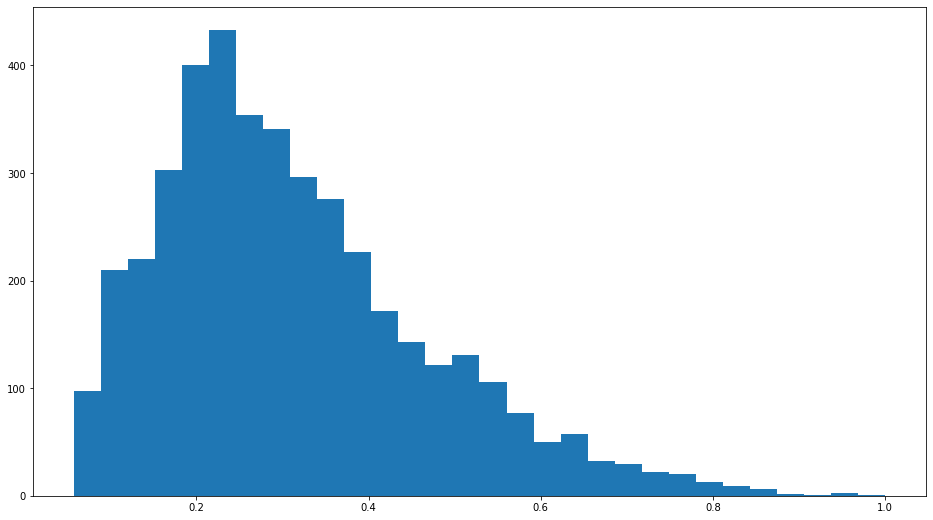

In [20]:
ensemble_Prob = (df['fold_0_1']+df['fold_1_1']+df['fold_2_1']+df['fold_3_1']+df['fold_4_1'])/5
plt.figure(figsize=(16,9))
# plt.plot(ensemble_Prob)
plt.hist(ensemble_Prob, bins=30)
plt.show()

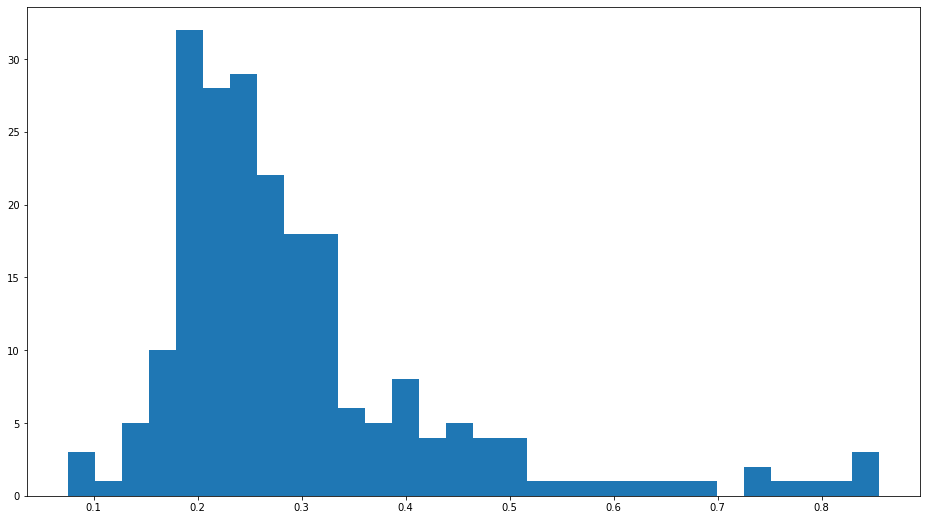

In [21]:
plt.figure(figsize=(16,9))
# plt.plot(df_external['ensemble_Prob'])
plt.hist(df_external['ensemble_Prob'], bins=30)
plt.show()

In [ ]:
## K-Fold CV Grid Search - random_seed, k-fold ensemble

# features = ['ini_nih', 'age', 'END']
features = ['ini_nih', 'age', 'END', 'i_glu', 'hx_str']
label = 'bad_outcome_3m'
mode = 'ensemble' # mode = fold, ensemble

save_path = './model_save/multimodal/'

result_multimodal_LR_kfold_df = []
result_multimodal_RF_kfold_df = []
result_multimodal_LGBM_kfold_df = []

r_range = 4;
for r in tqdm(range(r_range, r_range+1)):
    rand_seed = r

    torch.manual_seed(rand_seed)
    torch.cuda.manual_seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)
    np.random.seed(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    random.seed(rand_seed)
    os.environ["PYTHONHASHSEED"] = str(rand_seed)

    ## Machine Learning

    ## K-Fold
    test_prob_LR_ensemble = np.zeros((len(df[df['fold_0'] == 2]), 2))
    test_prob_RF_ensemble = np.zeros((len(df[df['fold_0'] == 2]), 2))
    test_prob_LGBM_ensemble = np.zeros((len(df[df['fold_0'] == 2]), 2))
    external_prob_LR_ensemble  = np.zeros((len(df_external), 2))
    external_prob_RF_ensemble = np.zeros((len(df_external), 2))
    external_prob_LGBM_ensemble  = np.zeros((len(df_external), 2))

    result_LR_kfold_df = []
    result_RF_kfold_df = []
    result_LGBM_kfold_df = []

    LR_test_prob = []
    RF_test_prob = []
    LGBM_test_prob = []
    RF_external_prob = []
    LR_external_prob = []
    LGBM_external_prob = []
    
    for fold in tqdm(range(0,5)):
        
        X_train, y_train, X_valid, y_valid, X_test, y_test = \
        train_val_test_split_by_fold(df, features, label, fold_num=fold)
        X_external, y_external = external_split_by_fold(df_external, features, label, fold_num=fold, mode=mode) # mode = fold, ensemble
        
        scaler = MinMaxScaler()
        X_train[features] = scaler.fit_transform(X_train[features])
        X_valid[features] = scaler.transform(X_valid[features])
        X_test[features] = scaler.transform(X_test[features])
        X_external[features] = scaler.transform(X_external[features])
        
        ### Logistic Regression ###
        logistic_regression_model = LogisticRegression()        
        model_LR_kfold = logistic_regression_model.fit(X_train, y_train)
        predict_LR_kfold = model_LR_kfold.predict(X_valid)
        valid_prob = model_LR_kfold.predict_proba(X_valid)
        test_prob = model_LR_kfold.predict_proba(X_test)
        external_prob = model_LR_kfold.predict_proba(X_external)
        
        model_metrics = {}
        model_metrics['k'] = fold+1
        # model_metrics['LogisticRegression: Accuracy'] = accuracy_score(y_valid, predict_LR_kfold)
        # model_metrics['LogisticRegression: Precision'] = precision_score(y_valid, predict_LR_kfold)
        # model_metrics['LogisticRegression: Recall'] = recall_score(y_valid, predict_LR_kfold)
        # model_metrics['LogisticRegression: F1 score'] = f1_score(y_valid, predict_LR_kfold)
        model_metrics['LogisticRegression: AUC_valid'] = roc_auc_score(y_valid, valid_prob[:, 1])
        model_metrics['LogisticRegression: AUC_test'] = roc_auc_score(y_test, test_prob[:, 1])
        model_metrics['LogisticRegression: AUC_External'] = roc_auc_score(y_external, external_prob[:, 1])
        result_LR_kfold_df.append(model_metrics)
        
        test_prob_LR_ensemble += test_prob
        external_prob_LR_ensemble += external_prob
                
        ### Random Forest Classifier ###
        random_forest_model = RandomForestClassifier(n_estimators=120, max_depth=4, n_jobs=-1, random_state=rand_seed)   
        
        model_RF_kfold = random_forest_model.fit(X_train, y_train)
        predict_RF_kfold = model_RF_kfold.predict(X_valid)
        valid_prob = model_RF_kfold.predict_proba(X_valid)
        test_prob = model_RF_kfold.predict_proba(X_test)
        external_prob = model_RF_kfold.predict_proba(X_external)

        model_metrics = {}
        model_metrics['k'] = fold+1
        # model_metrics['RandomForest: Accuracy'] = accuracy_score(y_valid, predict_RF_kfold)
        # model_metrics['RandomForest: Precision'] = precision_score(y_valid, predict_RF_kfold)
        # model_metrics['RandomForest: Recall'] = recall_score(y_valid, predict_RF_kfold)
        # model_metrics['RandomForest: F1 score'] = f1_score(y_valid, predict_RF_kfold)
        model_metrics['RandomForest: AUC_valid'] = roc_auc_score(y_valid, valid_prob[:, 1])
        model_metrics['RandomForest: AUC_test'] = roc_auc_score(y_test, test_prob[:, 1])
        model_metrics['RandomForest: AUC_External'] = roc_auc_score(y_external, external_prob[:, 1])
        result_RF_kfold_df.append(model_metrics)

        test_prob_RF_ensemble += test_prob
        external_prob_RF_ensemble += external_prob
            
        ### Light GBM ###
        lightgbm.early_stopping(stopping_rounds=20, verbose=0)
        Light_GBM_model = LGBMClassifier(n_estimators=200, learning_rate=1e-2, max_depth=4, num_leaves=5, 
                                         subsample=0.7, random_state=rand_seed)
        model_LGBM_kfold = Light_GBM_model.fit(X_train, y_train, eval_set=[(X_valid,y_valid)], verbose=0)
        predict_LGBM_kfold = model_LGBM_kfold.predict(X_valid)
        valid_prob = model_LGBM_kfold.predict_proba(X_valid)
        test_prob = model_LGBM_kfold.predict_proba(X_test)
        external_prob = model_LGBM_kfold.predict_proba(X_external)

        model_metrics = {}
        model_metrics['k'] = fold+1
        # model_metrics['LigthGBM: Accuracy'] = accuracy_score(y_valid, predict_LGBM_kfold)
        # model_metrics['LigthGBM: Precision'] = precision_score(y_valid, predict_LGBM_kfold)
        # model_metrics['LigthGBM: Recall'] = recall_score(y_valid, predict_LGBM_kfold)
        # model_metrics['LigthGBM: F1 score'] = f1_score(y_valid, predict_LGBM_kfold)
        model_metrics['LigthGBM: AUC_valid'] = roc_auc_score(y_valid, valid_prob[:, 1])
        model_metrics['LigthGBM: AUC_test'] = roc_auc_score(y_test, test_prob[:, 1])
        model_metrics['LigthGBM: AUC_External'] = roc_auc_score(y_external, external_prob[:, 1])
        result_LGBM_kfold_df.append(model_metrics)        

        test_prob_LGBM_ensemble += test_prob
        external_prob_LGBM_ensemble += external_prob


        ### model save ###
        # model_save_filename = save_path + 'model_LR_' + str(len(features)) + '_fold' + str(fold) + '.pkl'
        # with open(model_save_filename, 'wb') as fw:
        #     pickle.dump(model_LR_kfold, fw)
        # LR_test_prob.append(test_prob[:, 1])
        # LR_external_prob.append(external_prob[:,1])
        
        # model_save_filename = save_path + 'model_RF_' + str(len(features)) + '_fold' + str(fold) + '.pkl'
        # with open(model_save_filename, 'wb') as fw:
        #     pickle.dump(model_RF_kfold, fw)
        # RF_test_prob.append(test_prob[:, 1])
        # RF_external_prob.append(external_prob[:,1])

        # model_save_filename = save_path + 'model_LGBM_' + str(len(features)) + '_fold' + str(fold) + '.pkl'
        # with open(model_save_filename, 'wb') as fw:
        #     pickle.dump(model_LGBM_kfold, fw)
        # LGBM_test_prob.append(test_prob[:, 1])
        # LGBM_external_prob.append(external_prob[:,1])

    result_LR_kfold_df = pd.DataFrame(result_LR_kfold_df)
    result_RF_kfold_df = pd.DataFrame(result_RF_kfold_df)
    result_LGBM_kfold_df = pd.DataFrame(result_LGBM_kfold_df)

    model_grid_metrics = {}
    model_grid_metrics['Seed'] = r
    model_grid_metrics['Mean_Valid_LR_AUC'] = result_LR_kfold_df['LogisticRegression: AUC_valid'].mean()
    model_grid_metrics['Mean_Test_LR_AUC'] = result_LR_kfold_df['LogisticRegression: AUC_test'].mean()
    model_grid_metrics['Ensemble_Test_LR_AUC'] = roc_auc_score(y_test, test_prob_LR_ensemble[:, 1]/5)
    model_grid_metrics['Mean_External_LR_AUC'] = result_LR_kfold_df['LogisticRegression: AUC_External'].mean()
    model_grid_metrics['Ensemble_External_LR_AUC'] = roc_auc_score(y_external, external_prob_LR_ensemble[:, 1]/5)
    result_multimodal_LR_kfold_df.append(model_grid_metrics)

    model_grid_metrics = {}
    model_grid_metrics['Seed'] = r
    model_grid_metrics['Mean_Valid_RF_AUC'] = result_RF_kfold_df['RandomForest: AUC_valid'].mean()
    model_grid_metrics['Mean_Test_RF_AUC'] = result_RF_kfold_df['RandomForest: AUC_test'].mean()
    model_grid_metrics['Ensemble_Test_RF_AUC'] = roc_auc_score(y_test, test_prob_RF_ensemble[:, 1]/5)
    model_grid_metrics['Mean_External_RF_AUC'] = result_RF_kfold_df['RandomForest: AUC_External'].mean()
    model_grid_metrics['Ensemble_External_RF_AUC'] = roc_auc_score(y_external, external_prob_RF_ensemble[:, 1]/5)
    result_multimodal_RF_kfold_df.append(model_grid_metrics)

    model_grid_metrics = {}
    model_grid_metrics['Seed'] = r
    model_grid_metrics['Mean_Valid_LGBM_AUC'] = result_LGBM_kfold_df['LigthGBM: AUC_valid'].mean()
    model_grid_metrics['Mean_Test_LGBM_AUC'] = result_LGBM_kfold_df['LigthGBM: AUC_test'].mean()
    model_grid_metrics['Ensemble_Test_LGBM_AUC'] = roc_auc_score(y_test, test_prob_LGBM_ensemble[:, 1]/5)
    model_grid_metrics['Mean_External_LGBM_AUC'] = result_LGBM_kfold_df['LigthGBM: AUC_External'].mean()
    model_grid_metrics['Ensemble_External_LGBM_AUC'] = roc_auc_score(y_external, external_prob_LGBM_ensemble[:, 1]/5)
    result_multimodal_LGBM_kfold_df.append(model_grid_metrics)

LR_test_prob = pd.DataFrame(LR_test_prob).T
RF_test_prob = pd.DataFrame(RF_test_prob).T
LGBM_test_prob = pd.DataFrame(LGBM_test_prob).T
LR_external_prob = pd.DataFrame(LR_external_prob).T
RF_external_prob = pd.DataFrame(RF_external_prob).T
LGBM_external_prob = pd.DataFrame(LGBM_external_prob).T

result_multimodal_LR_kfold_df = pd.DataFrame(result_multimodal_LR_kfold_df)
result_multimodal_RF_kfold_df = pd.DataFrame(result_multimodal_RF_kfold_df)
result_multimodal_LGBM_kfold_df = pd.DataFrame(result_multimodal_LGBM_kfold_df)

disp(pd.DataFrame(result_multimodal_LR_kfold_df.mean()).transpose())
disp(pd.DataFrame(result_multimodal_RF_kfold_df.mean()).transpose())
disp(pd.DataFrame(result_multimodal_LGBM_kfold_df.mean()).transpose())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Seed  Mean_Valid_LR_AUC  Mean_Test_LR_AUC  Ensemble_Test_LR_AUC  \
0   4.0           0.752263          0.780835              0.786135   

   Mean_External_LR_AUC  Ensemble_External_LR_AUC  
0              0.861259                  0.862471

Seed  Mean_Valid_RF_AUC  Mean_Test_RF_AUC  Ensemble_Test_RF_AUC  \
0   4.0           0.758557          0.780128              0.786079   

   Mean_External_RF_AUC  Ensemble_External_RF_AUC  
0              0.885897                  0.887413

Seed  Mean_Valid_LGBM_AUC  Mean_Test_LGBM_AUC  Ensemble_Test_LGBM_AUC  \
0   4.0             0.753178             0.77836                 0.78674   

   Mean_External_LGBM_AUC  Ensemble_External_LGBM_AUC  
0                0.878403                    0.882751

In [ ]:
disp(pd.DataFrame(result_multimodal_LR_kfold_df.mean()).transpose())
disp(pd.DataFrame(result_multimodal_RF_kfold_df.mean()).transpose())
disp(pd.DataFrame(result_multimodal_LGBM_kfold_df.mean()).transpose())
disp('--------------------------------------------------------------------------------------------------------------------------')
# disp(pd.DataFrame(result_multimodal_LR_kfold_df))
disp(pd.DataFrame(result_multimodal_RF_kfold_df).sort_values(by=['Ensemble_Test_RF_AUC']))
# disp(pd.DataFrame(result_multimodal_LGBM_kfold_df))
# disp(pd.DataFrame(result_LR_kfold_df))
# disp(pd.DataFrame(result_RF_kfold_df))
# disp(pd.DataFrame(result_LGBM_kfold_df))

Seed  Mean_Valid_LR_AUC  Mean_Test_LR_AUC  Ensemble_Test_LR_AUC  \
0  53.5           0.752263          0.780835              0.786135   

   Mean_External_LR_AUC  Ensemble_External_LR_AUC  
0              0.861259                  0.862471

Seed  Mean_Valid_RF_AUC  Mean_Test_RF_AUC  Ensemble_Test_RF_AUC  \
0  53.5           0.758609          0.779317               0.78529   

   Mean_External_RF_AUC  Ensemble_External_RF_AUC  
0              0.886714                  0.888323

Seed  Mean_Valid_LGBM_AUC  Mean_Test_LGBM_AUC  Ensemble_Test_LGBM_AUC  \
0  53.5             0.753178             0.77836                 0.78674   

   Mean_External_LGBM_AUC  Ensemble_External_LGBM_AUC  
0                0.878403                    0.882751

'--------------------------------------------------------------------------------------------------------------------------'

Seed  Mean_Valid_RF_AUC  Mean_Test_RF_AUC  Ensemble_Test_RF_AUC  \
53    57           0.757545          0.777452              0.783150   
3      7           0.757768          0.778122              0.783723   
30    34           0.757537          0.778718              0.784034   
24    28           0.758198          0.778352              0.784098   
60    64           0.758070          0.778723              0.784147   
..   ...                ...               ...                   ...   
64    68           0.758450          0.780431              0.786489   
42    46           0.758877          0.780294              0.786517   
27    31           0.758974          0.780464              0.786694   
96   100           0.758256          0.780754              0.786843   
46    50           0.757830          0.780586              0.787168   

    Mean_External_RF_AUC  Ensemble_External_RF_AUC  
53              0.886270                  0.888228  
3               0.885699                  0.887646  
30              0.884499                  0.885781  
24              0.885455                  0.887413  
60              0.888112                  0.888695  
..                   ...                       ...  
64              0.884569                  0.886131  
42              0.886760                  0.888462  
27              0.884044                  0.886597  
96              0.886713                  0.888462  
46              0.884336                  0.886014  

[100 rows x 6 columns]

In [ ]:
with open('./model_save/multimodal/prob_LR_test_' + str(len(features)) + '.pkl', 'wb') as fw:
    pickle.dump(LR_test_prob, fw)
with open('./model_save/multimodal/prob_RF_test_' + str(len(features)) + '.pkl', 'wb') as fw:
    pickle.dump(RF_test_prob, fw)
with open('./model_save/multimodal/prob_LGBM_test_' + str(len(features)) + '.pkl', 'wb') as fw:
    pickle.dump(LGBM_test_prob, fw)
with open('./model_save/multimodal/prob_LR_external_' + str(len(features)) + '.pkl', 'wb') as fw:
    pickle.dump(LR_external_prob, fw)
with open('./model_save/multimodal/prob_RF_external_' + str(len(features)) + '.pkl', 'wb') as fw:
    pickle.dump(RF_external_prob, fw)
with open('./model_save/multimodal/prob_LGBM_external_' + str(len(features)) + '.pkl', 'wb') as fw:
    pickle.dump(LGBM_external_prob, fw)

In [ ]:
# ### K-Fold CV Grid Search using GridSearchCV ###
# ### Random Forest ###

# grid_parameter = {'n_estimators' : list(range(50, 310, 10)),
#                   'max_depth' : list(range(3, 10, 1)),
#                 #   'min_samples_leaf' : list(range(1, 6, 1)),
#                 #   'min_samples_split' : list(range(2, 7, 1))
#                   }                  
#                 #   'random_state' : list(range(0, 10))}

# Grid_metrics_result = []
# Best_parameter_result = []
# for r in tqdm(range(4, 5)):
#     rand_seed = r

#     torch.manual_seed(rand_seed)
#     torch.cuda.manual_seed(rand_seed)
#     torch.cuda.manual_seed_all(rand_seed)
#     np.random.seed(rand_seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False
#     random.seed(rand_seed)
#     os.environ["PYTHONHASHSEED"] = str(rand_seed)
    
#     X_train, y_train, X_valid, y_valid, X_test, y_test = \
#     train_val_test_split_by_fold(df, features, label, fold_num=3)
    
#     scaler = MinMaxScaler()
#     X_train[features] = scaler.fit_transform(X_train[features])
#     X_valid[features] = scaler.transform(X_valid[features])
#     X_test[features] = scaler.transform(X_test[features])
    
#     random_forest_model = RandomForestClassifier(random_state=rand_seed)
#     grid_search = GridSearchCV(estimator = random_forest_model, param_grid = grid_parameter, cv=2, n_jobs=-1, verbose=1)
#     grid_search.fit(X_train, y_train)
#     # print(f'random_state: {r}')
#     # disp(grid_search.score(X_test, y_test))
#     # disp(grid_search.best_score_)
#     # disp(grid_search.best_params_)
#     Grid_metrics = {}
#     Grid_metrics['random_state'] = rand_seed
#     Grid_metrics['Test_score'] = grid_search.score(X_test, y_test)
#     Grid_metrics['Best_score'] = grid_search.best_score_
#     Grid_metrics['Best_parameter'] = grid_search.best_params_
#     Grid_metrics_result.append(Grid_metrics)
#     Best_parameter_result.append(Grid_metrics['Best_parameter'])
#     disp(Grid_metrics['Best_parameter'])

# Grid_metrics_result_df = pd.DataFrame(Grid_metrics_result)
# Best_parameter_result_df = pd.DataFrame(Best_parameter_result)

# disp(pd.DataFrame(Grid_metrics_result_df))
# disp(pd.DataFrame(Best_parameter_result_df))

In [ ]:
# ### K-Fold CV Grid Search using GridSearchCV ###
# ### LigthBGM ###

# grid_parameter = {'max_depth' : [3,5,7],
#                   'num_leaves' : [4, 20, 100],
#                   'learning_rate' : [0.01, 0.05, 0.1],
#                   'subsample' : [0.7],
#                   }
# # grid_parameter = {'max_depth' : [3],
# #                   'num_leaves' : [3, 5, 7],
# #                   'learning_rate' : [0.01, 0.05, 0.1],
# #                   'subsample' : [0.7],
# #                   }

# Grid_metrics_result = []
# Best_parameter_result = []
# for r in tqdm(range(4, 5)):
#     rand_seed = r

#     torch.manual_seed(rand_seed)
#     torch.cuda.manual_seed(rand_seed)
#     torch.cuda.manual_seed_all(rand_seed)
#     np.random.seed(rand_seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False
#     random.seed(rand_seed)
#     os.environ["PYTHONHASHSEED"] = str(rand_seed)
    
#     train_valid_table = df.loc[(df['fold_0']=='train') | (df['fold_0']=='val')]
#     X_train = train_valid_table[select_columns]
#     y_train = train_valid_table['bad_outcome_3m']

#     scaler = MinMaxScaler()
#     X_train = pd.DataFrame(scaler.fit_transform(X_train))
#     X_test = pd.DataFrame(scaler.transform(X_test))
#     X_external = pd.DataFrame(scaler.transform(df_external[select_columns]))
    
#     lightgbm.early_stopping(stopping_rounds=20)
#     Light_GBM_model = LGBMClassifier(n_estimators=100, boosting='dart', random_state=rand_seed)
#     grid_search = GridSearchCV(estimator=Light_GBM_model, param_grid=grid_parameter, cv=5, n_jobs=-1, verbose=0)
#     grid_search.fit(X_train, y_train, early_stopping_rounds = 20, eval_set=[(X_test,y_test)], verbose=0)
#     # print(f'random_state: {r}')
#     # disp(grid_search.score(X_test, y_test))
#     # disp(grid_search.best_score_)
#     # disp(grid_search.best_params_)
#     Grid_metrics = {}
#     Grid_metrics['random_state'] = rand_seed
#     Grid_metrics['Test_score'] = grid_search.score(X_external, y_external)
#     Grid_metrics['Best_score'] = grid_search.best_score_
#     Grid_metrics['Best_parameter'] = grid_search.best_params_
#     Grid_metrics_result.append(Grid_metrics)
#     Best_parameter_result.append(Grid_metrics['Best_parameter'])
#     disp(Grid_metrics['Best_parameter'])

# Grid_metrics_result_df = pd.DataFrame(Grid_metrics_result)
# Best_parameter_result_df = pd.DataFrame(Best_parameter_result)

# disp(pd.DataFrame(Grid_metrics_result_df))
# disp(pd.DataFrame(Best_parameter_result_df))

In [22]:
### Multi Layer Perceptron ###

In [23]:
class CustomDataset(Dataset):
  def __init__(self, x, y):
    if type(x) is np.ndarray:
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
    else:           
        self.x = torch.FloatTensor(x.values)
        self.y = torch.FloatTensor(y.values)
  
  def __getitem__(self, index):
    return self.x[index], self.y[index]
  
  def __len__(self):
    return len(self.y)

In [24]:
def binary_acc(y_pred, y_test, threshold):    
    
#     y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred_tag = (y_pred > threshold).float()
#     y_pred_tag = y_pred.argmax()   
    
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
#     acc = torch.round(acc * 100)
    acc = acc * 100
    
    return acc

In [25]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        # if self.verbose:
        #     self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [26]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    input_layer = len(features) + 1
    hidden_1 = 200
    hidden_2 = 100
    hidden_3 = 1
    output_layer = 2
    alpha = 0.2
    self.fc1 = nn.Linear(input_layer, hidden_1)
    self.fc2 = nn.Linear(hidden_1,hidden_2)
    self.fc3 = nn.Linear(hidden_2,hidden_3)
    self.fc4 = nn.Linear(hidden_3,input_layer)
    self.fc5 = nn.Linear(hidden_2,output_layer)
    self.ReLU = nn.ReLU()
    self.ELU = nn.ELU()
    self.LeReLU = nn.LeakyReLU(negative_slope=alpha) 
    self.Sig = nn.Sigmoid()
    self.Soft = nn.Softmax()
    self.dropout = nn.Dropout(0.2)
    self.Batchnorm1 = nn.BatchNorm1d(hidden_1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.Batchnorm2 = nn.BatchNorm1d(hidden_2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.Batchnorm3 = nn.BatchNorm1d(hidden_3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.Batchnorm4 = nn.BatchNorm1d(input_layer, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    nn.init.kaiming_uniform_(self.fc1.weight, a=alpha, mode='fan_in', nonlinearity='leaky_relu')
    nn.init.kaiming_uniform_(self.fc2.weight, a=alpha, mode='fan_in', nonlinearity='leaky_relu')
    nn.init.kaiming_uniform_(self.fc3.weight, a=alpha, mode='fan_in', nonlinearity='leaky_relu')
    nn.init.kaiming_normal_(self.fc4.weight, a=alpha, mode='fan_in', nonlinearity='leaky_relu')  
    nn.init.xavier_normal_(self.fc5.weight)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)
    nn.init.zeros_(self.fc3.bias)
    nn.init.zeros_(self.fc4.bias)
    nn.init.zeros_(self.fc5.bias)
    
  def forward(self, x):
    if len(x) == 1:
        x = self.LeReLU(self.fc1(x))
        # x = self.LeReLU(self.fc2(x))
        x = self.fc5(x)
    else:
        # x = self.dropout(self.Batchnorm1(self.LeReLU(self.fc1(x))))
        x = self.fc1(x)
        x = self.LeReLU(x)
        x = self.Batchnorm1(x)
        x = self.dropout(x)

        # x = self.dropout(self.Batchnorm2(self.LeReLU(self.fc2(x))))
        x = self.fc2(x)
        x = self.LeReLU(x)
        x = self.Batchnorm2(x)
        x = self.dropout(x)

        # x = self.dropout(self.Batchnorm2(self.LeReLU(self.fc2(x))))
        # x = self.fc3(x)
        # x = self.LeReLU(x)
        # x = self.Batchnorm3(x)
        # x = self.dropout(x)

    #     x = self.dropout(self.Batchnorm4(self.ReLU(self.fc4(x))))
    #     nn.init.kaiming_uniform_(x, mode='fan_out', nonlinearity='relu')
        x = self.fc5(x)
    #     x = self.Soft(x)
    return x

In [31]:
### MLP Train ###

# features = ['ini_nih', 'age', 'END']
features = ['ini_nih', 'age', 'END', 'i_glu', 'hx_str']
label = 'bad_outcome_3m'
mode = 'ensemble' # mode = fold, ensemble

save_path = './model_save/multimodal/'

result_multimodal_MLP_kfold_df = []

r_range = 4;
for r in range(r_range, r_range+1):
    rand_seed = r
    torch.manual_seed(rand_seed)
    torch.cuda.manual_seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    os.environ["PYTHONHASHSEED"] = str(rand_seed)
    
    models = []
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    result_MLP_kfold_df = []
    MLP_test_prob = []
    MLP_external_prob = []
    
    test_prob_MLP_ensemble = torch.tensor(  np.zeros( (  len(df[df['fold_0'] == 2]), 2  )  )  )
    external_prob_MLP_ensemble = torch.tensor(  np.zeros((len(df_external), 2))  )

    # num_epochs = 5000
    batch_size = 64
    learning_rate = 1e-4
    
    if learning_rate <= 1e-5:
        num_epochs = 5000
        patience=20
    elif 1e-4 <= learning_rate < 1e-3:
        num_epochs = 2000
        patience=20
    elif 1e-3 <= learning_rate:
        num_epochs = 1000
        patience=20

    #patience = 20
    device = 'cpu'

    for fold in tqdm(range(0,5)):
        
        X_train, y_train, X_valid, y_valid, X_test, y_test = \
        train_val_test_split_by_fold(df, features, label, fold_num=fold)
        X_external, y_external = external_split_by_fold(df_external, features, label, fold_num=fold, mode=mode) # mode = fold, ensemble
        
        scaler = MinMaxScaler()
        X_train[features] = scaler.fit_transform(X_train[features])
        X_valid[features] = scaler.transform(X_valid[features])
        X_test[features] = scaler.transform(X_test[features])
        X_external[features] = scaler.transform(X_external[features])

        train_dataset = CustomDataset(X_train, y_train)
        train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
        valid_dataset = CustomDataset(X_valid, y_valid)
        valid_dataloader = DataLoader(valid_dataset, batch_size = 1024)
        test_dataset = CustomDataset(X_test, y_test)
        test_dataloader = DataLoader(test_dataset, batch_size = 1024)
        external_dataset = CustomDataset(X_external, y_external)
        external_dataloader = DataLoader(external_dataset, batch_size = 256)

        n = len(valid_dataloader)

        model = MLP()
        model = model.to(device)
        # criterion = nn.BCEWithLogitsLoss() # sigmoid
        criterion = nn.CrossEntropyLoss() # softmax
        # optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        early_stopping = EarlyStopping(patience=patience, delta=0, verbose=True)

        tepochs = trange(num_epochs)
        for epoch in tepochs:
    #     for epoch in tqdm(range(num_epochs)):
            train_loss = 0
            train_acc = 0
            valid_loss = 0
            valid_acc = 0
            for X_batch, y_batch in train_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()  

                y_pred = model(X_batch)

                # loss = criterion(y_pred, y_batch.unsqueeze(1)) # sigmoid
                loss = criterion(y_pred, y_batch.to(device=device, dtype=torch.int64)) # softmax

                loss.backward()
                optimizer.step()

    #             acc1 = binary_acc(y_pred, y_batch.unsqueeze(1), threshold = 0.35)

                train_loss += loss.item()
    #             train_acc += acc1.item()  

            model.eval().to('cpu'),
            correct = 0
            total = 0
            with torch.no_grad():
                for X_batch_val, y_batch_val in valid_dataloader:
                    X_batch_val, y_batch_val = X_batch_val, y_batch_val

                    y_pred_val = model(X_batch_val)
                    y_pred_val_prob = nn.functional.softmax(y_pred_val, dim=1)

                    # loss_val = criterion(y_pred_val, y_batch_val.unsqueeze(1)) # sigmoid
                    loss_val = criterion(y_pred_val, y_batch_val.to(device='cpu', dtype=torch.int64)) # softmax

    #                 acc2 = binary_acc(y_pred_val, y_batch_val.unsqueeze(1), threshold = 0.35)

                    valid_loss += loss_val.item()
    #                 valid_acc += acc2.item()

            train_loss_list.append(train_loss/len(train_dataloader))        
    #         train_acc_list.append(train_acc/len(train_dataloader))
            valid_loss_list.append(valid_loss/len(valid_dataloader))
    #         valid_acc_list.append(valid_acc/len(valid_dataloader))

    #         if epoch % (50) == 0:
    #             print(f'Epoch: {epoch+0:03} | Train_Loss: {train_loss/len(train_dataloader):.5f} | Valid_Loss: {valid_loss/len(valid_dataloader):.5f} | Acc: {valid_acc/len(valid_dataloader):.3f} | AUC : {roc_auc_score(y_batch_val.cpu(), y_pred_val.cpu()):.3f}')
    #             print(f'Epoch: {epoch+0:03} | Train_Loss: {train_loss/len(train_dataloader):.5f} | Valid_Loss: {valid_loss/len(valid_dataloader):.5f} | Acc: {valid_acc/len(valid_dataloader):.3f} | AUC : {roc_auc_score(y_batch_val.cpu(), y_pred_val[:,1].cpu()):.3f}')

            tepochs.set_description(f"Seed {r} | Fold {fold+1}")
            ### sigmoid ###
            # tepochs.set_postfix(Train_Loss=train_loss/len(train_dataloader), Valid_Loss=valid_loss/len(valid_dataloader), AUC=roc_auc_score(y_batch_val.cpu(), y_pred_val.cpu()))
            ### softmax ###
            tepochs.set_postfix(Train_Loss=train_loss/len(train_dataloader), Valid_Loss=valid_loss/len(valid_dataloader), 
                                val_AUC=roc_auc_score(y_batch_val.cpu(), y_pred_val_prob[:,1].cpu()))
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
    #             print(f'Epoch: {epoch+0:03} | Train_Loss: {train_loss/len(train_dataloader):.5f} | Valid_Loss: {valid_loss/len(valid_dataloader):.5f} | Acc: {valid_acc/len(valid_dataloader):.3f} | AUC : {roc_auc_score(y_batch_val.cpu(), y_pred_val.cpu()):.3f}')
    #             print(f'Epoch: {epoch+0:03} | Train_Loss: {train_loss/len(train_dataloader):.5f} | Valid_Loss: {valid_loss/len(valid_dataloader):.5f} | AUC : {roc_auc_score(y_batch_val.cpu(), y_pred_val.cpu()):.3f}')
                break

    #     train_loss_list.append(train_loss/len(train_dataloader))        
    #     train_acc_list.append(train_acc/len(train_dataloader))
    #     valid_loss_list.append(valid_loss/len(valid_dataloader))
    #     valid_acc_list.append(valid_acc/len(valid_dataloader))
    
        model.load_state_dict(torch.load('checkpoint.pt'))

        with torch.no_grad():
            model.eval().to('cpu')
            for X_batch_test, y_batch_test in test_dataloader:
                y_pred_test = model(X_batch_test)
                y_pred_test_prob = nn.functional.softmax(y_pred_test, dim=1)
                test_prob_MLP_ensemble += y_pred_test

        with torch.no_grad():
            model.eval().to('cpu')
            for X_batch_external, y_batch_external in external_dataloader:
                y_pred_external = model(X_batch_external)
                y_pred_external_prob = nn.functional.softmax(y_pred_external, dim=1)
                external_prob_MLP_ensemble += y_pred_external

        model_metrics = {}
        model_metrics['k'] = fold+1
        # model_metrics['MLP_AUC'] = roc_auc_score(y_batch_val.cpu(), y_pred_val.cpu()) # sigmoid
        # model_metrics['Test_MLP_AUC'] = roc_auc_score(y_test, y_test_pred)
        # model_metrics['External_MLP_AUC'] = roc_auc_score(y_external, y_external_pred)
        model_metrics['Valid_MLP_AUC'] = roc_auc_score(y_batch_val.cpu(), y_pred_val_prob[:,1].cpu()) # softmax
        model_metrics['Test_MLP_AUC'] = roc_auc_score(y_test, y_pred_test_prob[:,1])
        model_metrics['External_MLP_AUC'] = roc_auc_score(y_external, y_pred_external_prob[:,1]) 
        result_MLP_kfold_df.append(model_metrics)
        
        MLP_test_prob.append(y_pred_test_prob[:,1].numpy())
        MLP_external_prob.append(y_pred_external_prob[:,1].numpy())

        ### model save ###
        # model_save_filename = save_path + 'model_MLP_' + str(len(features)) + '_fold' + str(fold) + '.pt'
        # torch.save(model.state_dict(), model_save_filename)

    test_prob_MLP_ensemble = nn.functional.softmax(test_prob_MLP_ensemble, dim=1)
    external_prob_MLP_ensemble = nn.functional.softmax(external_prob_MLP_ensemble, dim=1)    

#         models += [model]
    result_MLP_kfold_df = pd.DataFrame(result_MLP_kfold_df)
    model_grid_metrics = {}
    model_grid_metrics['random_seed'] = r
    model_grid_metrics['Mean_valid_AUC'] = result_MLP_kfold_df['Valid_MLP_AUC'].mean()
    model_grid_metrics['Mean_test_AUC'] = result_MLP_kfold_df['Test_MLP_AUC'].mean()
    model_grid_metrics['Ensemble_Test_MLP_AUC'] = roc_auc_score(y_test, test_prob_MLP_ensemble[:, 1]/5)
    model_grid_metrics['Mean_External_MLP_AUC'] = result_MLP_kfold_df['External_MLP_AUC'].mean()
    model_grid_metrics['Ensemble_External_MLP_AUC'] = roc_auc_score(y_external, external_prob_MLP_ensemble[:, 1]/5)
    result_multimodal_MLP_kfold_df.append(model_grid_metrics)
    
    disp(pd.DataFrame(pd.DataFrame(result_multimodal_MLP_kfold_df).mean()).transpose())

MLP_test_prob = pd.DataFrame(MLP_test_prob).T
MLP_external_prob = pd.DataFrame(MLP_external_prob).T
result_multimodal_MLP_kfold_df = pd.DataFrame(result_multimodal_MLP_kfold_df)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Early stopping


  0%|          | 0/2000 [00:00<?, ?it/s]

Early stopping


  0%|          | 0/2000 [00:00<?, ?it/s]

Early stopping


  0%|          | 0/2000 [00:00<?, ?it/s]

Early stopping


  0%|          | 0/2000 [00:00<?, ?it/s]

Early stopping


random_seed  Mean_valid_AUC  Mean_test_AUC  Ensemble_Test_MLP_AUC  \
0          4.0        0.754724       0.782859               0.792183   

   Mean_External_MLP_AUC  Ensemble_External_MLP_AUC  
0               0.878089                   0.881702

In [32]:
disp(pd.DataFrame((result_multimodal_MLP_kfold_df.drop(columns = 'random_seed')).mean()).transpose())
disp('---------------------------------------------------------------------------------------------------------------------------------------')
disp(pd.DataFrame((result_MLP_kfold_df)))
# disp(result_MLP_kfold_grid_df.sort_values('Ensemble_External_MLP_AUC'))

Mean_valid_AUC  Mean_test_AUC  Ensemble_Test_MLP_AUC  \
0        0.754724       0.782859               0.792183   

   Mean_External_MLP_AUC  Ensemble_External_MLP_AUC  
0               0.878089                   0.881702

'---------------------------------------------------------------------------------------------------------------------------------------'

k  Valid_MLP_AUC  Test_MLP_AUC  External_MLP_AUC
0  1       0.754952      0.780702          0.880303
1  2       0.744535      0.784119          0.871445
2  3       0.766379      0.784324          0.879953
3  4       0.751805      0.780094          0.885781
4  5       0.755950      0.785053          0.872960

In [33]:
with open('./model_save/multimodal/prob_MLP_test_' + str(len(features)) + '.pkl', 'wb') as fw:
    pickle.dump(MLP_test_prob, fw)
with open('./model_save/multimodal/prob_MLP_external_' + str(len(features)) + '.pkl', 'wb') as fw:
    pickle.dump(MLP_external_prob, fw)

Epoch: 53
Valid_AUC: 0.7559500168036418


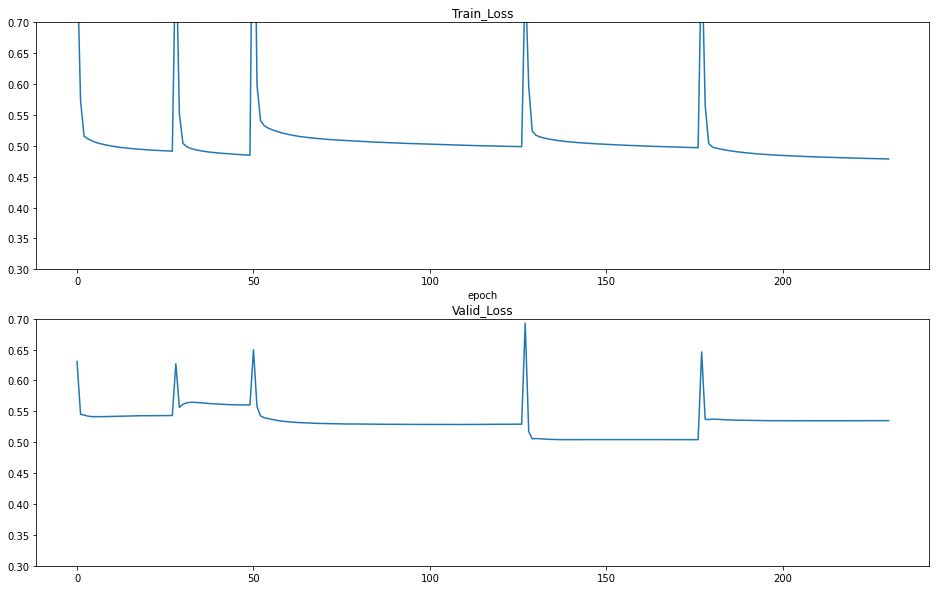

In [ ]:
print(f'Epoch: {epoch}')
# print(f'Train_Acc: {train_acc/len(train_dataloader)}')
# print(f'Valid_Acc: {valid_acc/len(valid_dataloader)}')
print(f'Valid_AUC: {roc_auc_score(y_batch_val.cpu(), y_pred_val_prob[:,1].cpu())}')
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
ax[0].plot(train_loss_list)
ax[0].set_title('Train_Loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylim([0.3, 0.7])
ax[1].plot(valid_loss_list)
ax[1].set_title('Valid_Loss')
ax[1].set_ylim([0.3, 0.7])
# ax[0, 0].plot(train_loss_list)
# ax[0, 0].set_title('Train_Loss')
# ax[0, 0].set_xlabel('epoch')
# ax[0, 1].plot(valid_loss_list)
# ax[0, 1].set_title('Valid_Loss')
# ax[1, 0].plot(train_acc_list)
# ax[1, 0].set_ylim([min(train_acc_list)-10, max(train_acc_list)+10])
# ax[1, 0].set_title('Train_Accuracy')
# ax[1, 1].plot(valid_acc_list)
# ax[1, 1].set_ylim([min(train_acc_list)-10, max(train_acc_list)+10])
# ax[1, 1].set_title('Valid_Accuracy')
plt.show()


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, test_prob_MLP_ensemble[:,1])

J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (test_prob_MLP_ensemble[:,1].numpy() >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))


Best Threshold=0.002640, sensitivity = 0.816, specificity = 0.648, J=0.465
              precision    recall  f1-score   support

      normal       0.89      0.65      0.75       577
    abnormal       0.50      0.82      0.62       245

    accuracy                           0.70       822
   macro avg       0.69      0.73      0.68       822
weighted avg       0.77      0.70      0.71       822



Test_AUC : 0.7921833551444841


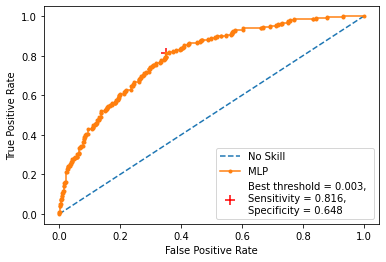

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, test_prob_MLP_ensemble[:,1])
J = tpr - fpr
ix = argmax(J)
sens, spec = tpr[ix], 1-fpr[ix]

print(f'Test_AUC : {roc_auc_score(y_test, test_prob_MLP_ensemble[:,1])}')

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='MLP')
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

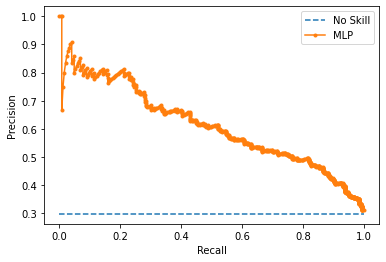

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_prob_MLP_ensemble[:,1])
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_external, external_prob_MLP_ensemble[:,1])

J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (external_prob_MLP_ensemble[:,1].numpy() >= best_thresh).astype(bool)
print(classification_report(y_external, y_prob_pred, target_names=['normal', 'abnormal']))


Best Threshold=0.006941, sensitivity = 0.846, specificity = 0.776, J=0.622
              precision    recall  f1-score   support

      normal       0.94      0.78      0.85       165
    abnormal       0.54      0.85      0.66        52

    accuracy                           0.79       217
   macro avg       0.74      0.81      0.76       217
weighted avg       0.85      0.79      0.81       217



Test_AUC : 0.8817016317016316


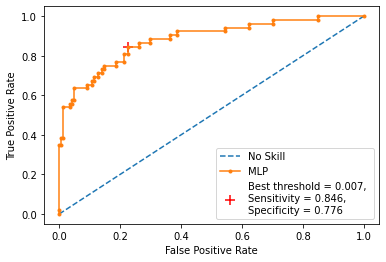

In [ ]:
ns_probs = [0 for _ in range(len(y_external))]
ns_auc = roc_auc_score(y_external, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_external, ns_probs)
fpr, tpr, _ = roc_curve(y_external, external_prob_MLP_ensemble[:,1])
J = tpr - fpr
ix = argmax(J)
sens, spec = tpr[ix], 1-fpr[ix]

print(f'Test_AUC : {roc_auc_score(y_external, external_prob_MLP_ensemble[:,1])}')

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='MLP')
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

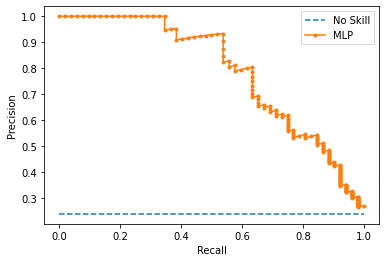

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(y_external, external_prob_MLP_ensemble[:,1])
no_skill = len(y_external[y_external==1]) / len(y_external)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()